# Hammerhead Shark Optimization Algorithm (HSOA) para TSP

Este notebook implementa el algoritmo HSOA adaptado al Problema del Viajante (TSP - Traveling Salesman Problem).

## Estructura del algoritmo:
1. **Inicialización**: Generar población de rutas aleatorias
2. **Búsqueda iterativa**: Exploración y explotación mediante operadores de movimiento
3. **Convergencia**: Movimiento hacia la mejor solución encontrada

## Importar librerías necesarias

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
import time

## Definición de la matriz de distancias y ciudades

In [14]:
def crear_matriz_distancias(num_ciudades: int, tipo: str = 'aleatoria') -> np.ndarray:
    """
    Crea una matriz de distancias entre ciudades.
    
    Args:
        num_ciudades: Número de ciudades
        tipo: 'aleatoria' para coordenadas aleatorias, 'simetrica' para matriz simétrica aleatoria
    
    Returns:
        Matriz de distancias (numpy array)
    """
    if tipo == 'aleatoria':
        # Generar coordenadas aleatorias para cada ciudad
        coordenadas = np.random.rand(num_ciudades, 2) * 100
        
        # Calcular matriz de distancias euclidiana
        matriz_distancias = np.zeros((num_ciudades, num_ciudades))
        for i in range(num_ciudades):
            for j in range(num_ciudades):
                if i != j:
                    dist = np.sqrt((coordenadas[i, 0] - coordenadas[j, 0])**2 + 
                                 (coordenadas[i, 1] - coordenadas[j, 1])**2)
                    matriz_distancias[i, j] = dist
        
        return matriz_distancias, coordenadas
    
    elif tipo == 'simetrica':
        # Generar matriz simétrica aleatoria
        matriz_distancias = np.random.rand(num_ciudades, num_ciudades) * 100
        matriz_distancias = (matriz_distancias + matriz_distancias.T) / 2
        np.fill_diagonal(matriz_distancias, 0)
        return matriz_distancias, None

# Ejemplo: Crear problema TSP con 20 ciudades
num_ciudades = 20
matriz_distancias, coordenadas = crear_matriz_distancias(num_ciudades, tipo='aleatoria')

print(f"Problema TSP con {num_ciudades} ciudades")
print(f"Forma de la matriz de distancias: {matriz_distancias.shape}")
print(f"\nPrimeras 5x5 distancias:\n{matriz_distancias[:5, :5]}")

Problema TSP con 20 ciudades
Forma de la matriz de distancias: (20, 20)

Primeras 5x5 distancias:
[[ 0.         50.17136011 82.42154906 32.75536921 33.19807081]
 [50.17136011  0.         72.64288903 72.50660878 17.05893848]
 [82.42154906 72.64288903  0.         71.69025114 70.91551038]
 [32.75536921 72.50660878 71.69025114  0.         56.55792068]
 [33.19807081 17.05893848 70.91551038 56.55792068  0.        ]]


## Matriz distancias & Hyperparámetros

In [ ]:
NUM_CIUDADES = 50 
MATRIZ_DISTANCIAS, COORDENADAS = crear_matriz_distancias(NUM_CIUDADES, tipo='aleatoria')

TAM_POBLACION = 30
PROB_EXPLOTACION = 0.3
NUM_SONARS = 5
MAX_ITERACIONES = 600


## Funciones auxiliares para el TSP

In [16]:
def calcular_distancia_ruta(ruta: List[int], matriz_distancias: np.ndarray) -> float:
    """
    Calcula la distancia total de una ruta.
    
    Args:
        ruta: Lista de índices de ciudades en el orden de visita
        matriz_distancias: Matriz de distancias entre ciudades
    
    Returns:
        Distancia total de la ruta
    """
    distancia_total = 0.0
    for i in range(len(ruta) - 1):
        distancia_total += matriz_distancias[ruta[i], ruta[i + 1]]
    # Añadir distancia de regreso a la ciudad inicial
    distancia_total += matriz_distancias[ruta[-1], ruta[0]]
    return distancia_total


def generar_ruta_aleatoria(num_ciudades: int) -> List[int]:
    """
    Genera una ruta aleatoria (permutación de ciudades).
    
    Args:
        num_ciudades: Número total de ciudades
    
    Returns:
        Lista con permutación aleatoria de índices de ciudades
    """
    ruta = list(range(num_ciudades))
    random.shuffle(ruta)
    return ruta


# Probar las funciones
ruta_ejemplo = generar_ruta_aleatoria(num_ciudades)
distancia_ejemplo = calcular_distancia_ruta(ruta_ejemplo, matriz_distancias)

print(f"Ruta ejemplo: {ruta_ejemplo[:10]}... (primeras 10 ciudades)")
print(f"Distancia total: {distancia_ejemplo:.2f}")

Ruta ejemplo: [10, 2, 15, 0, 14, 13, 3, 16, 6, 12]... (primeras 10 ciudades)
Distancia total: 1191.44


## Operadores de movimiento para exploración

In [17]:
def operador_swap(ruta: List[int]) -> List[int]:
    """
    Operador de intercambio (swap): intercambia dos ciudades aleatorias.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con dos ciudades intercambiadas
    """
    nueva_ruta = ruta.copy()
    i, j = random.sample(range(len(ruta)), 2)
    nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
    return nueva_ruta


def operador_inversion(ruta: List[int]) -> List[int]:
    """
    Operador de inversión: invierte un segmento aleatorio de la ruta.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con un segmento invertido
    """
    nueva_ruta = ruta.copy()
    i, j = sorted(random.sample(range(len(ruta)), 2))
    nueva_ruta[i:j+1] = reversed(nueva_ruta[i:j+1])
    return nueva_ruta


def operador_insercion(ruta: List[int]) -> List[int]:
    """
    Operador de inserción: extrae una ciudad y la inserta en otra posición.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con una ciudad reubicada
    """
    nueva_ruta = ruta.copy()
    i = random.randint(0, len(ruta) - 1)
    j = random.randint(0, len(ruta) - 1)
    ciudad = nueva_ruta.pop(i)
    nueva_ruta.insert(j, ciudad)
    return nueva_ruta


def aplicar_operador_movimiento(ruta: List[int], tipo: str = 'aleatorio') -> List[int]:
    """
    Aplica un operador de movimiento a la ruta.
    
    Args:
        ruta: Ruta original
        tipo: Tipo de operador ('swap', 'inversion', 'insercion', 'aleatorio')
    
    Returns:
        Nueva ruta modificada
    """
    if tipo == 'aleatorio':
        tipo = random.choice(['swap', 'inversion', 'insercion'])
    
    if tipo == 'swap':
        return operador_swap(ruta)
    elif tipo == 'inversion':
        return operador_inversion(ruta)
    elif tipo == 'insercion':
        return operador_insercion(ruta)
    else:
        raise ValueError(f"Tipo de operador desconocido: {tipo}")


# Probar operadores
print("Ruta original:", ruta_ejemplo[:10], "...")
print("Después de swap:", operador_swap(ruta_ejemplo)[:10], "...")
print("Después de inversión:", operador_inversion(ruta_ejemplo)[:10], "...")
print("Después de inserción:", operador_insercion(ruta_ejemplo)[:10], "...")

Ruta original: [10, 2, 15, 0, 14, 13, 3, 16, 6, 12] ...
Después de swap: [9, 2, 15, 0, 14, 13, 3, 16, 6, 12] ...
Después de inversión: [10, 2, 15, 0, 14, 11, 17, 7, 5, 9] ...
Después de inserción: [10, 2, 15, 0, 14, 13, 3, 16, 6, 12] ...


## Operador de combinación para explotación

In [ ]:
def combinar_rutas_orden(ruta: List[int], mejor_ruta: List[int]) -> List[int]:
    """
    Combina parcialmente una ruta con la mejor ruta preservando el orden.
    Copia segmentos de la mejor ruta manteniendo una permutación válida.
    """
    n = len(ruta)
    # Determinar longitud del segmento a copiar
    longitud_segmento = random.randint(n // 4, n // 2)
    inicio = random.randint(0, n - longitud_segmento)
    
    # Copiar segmento de la mejor ruta
    segmento = mejor_ruta[inicio:inicio + longitud_segmento]
    
    # Crear nueva ruta: colocar el segmento en la misma posición
    nueva_ruta = [None] * n
    nueva_ruta[inicio:inicio + longitud_segmento] = segmento
    
    # Completar con las ciudades restantes de la ruta original en orden
    ciudades_usadas = set(segmento)
    idx = 0
    for i in range(n):
        if nueva_ruta[i] is None:
            # Buscar siguiente ciudad no usada de la ruta original
            while ruta[idx] in ciudades_usadas:
                idx += 1
            nueva_ruta[i] = ruta[idx]
            ciudades_usadas.add(ruta[idx])
            idx += 1
    
    return nueva_ruta


# Probar combinación
ruta_test = generar_ruta_aleatoria(10)
mejor_ruta_test = generar_ruta_aleatoria(10)

print("Ruta original:", ruta_test)
print("Mejor ruta:", mejor_ruta_test)
print("Combinación por orden:", combinar_rutas_orden(ruta_test, mejor_ruta_test))

Ruta original: [5, 3, 0, 4, 7, 6, 2, 1, 8, 9]
Mejor ruta: [5, 0, 1, 3, 6, 4, 9, 8, 7, 2]
Combinación por orden: [5, 3, 0, 7, 6, 4, 9, 8, 2, 1]
Combinación por posición: [5, 0, 3, 4, 6, 8, 9, 1, 7, 2]


## Implementación del algoritmo HSOA para TSP

In [ ]:
class HSOA_TSP:
    
    def __init__(self, 
                 matriz_distancias: np.ndarray = MATRIZ_DISTANCIAS,
                 tam_poblacion: int = TAM_POBLACION,
                 max_iteraciones: int = MAX_ITERACIONES,
                 num_sonars: int = NUM_SONARS,
                 prob_explotacion: float = PROB_EXPLOTACION,
                 verbose: bool = True):
        """
        Inicializa el algoritmo HSOA para TSP.
        
        Args:
            matriz_distancias: Matriz de distancias entre ciudades
            tam_poblacion: Número de rutas en la población
            max_iteraciones: Número máximo de iteraciones
            num_sonars: Número de vecinos a evaluar en la fase de exploración (visión amplia del martillo)
            prob_explotacion: Probabilidad de combinar con mejor ruta
            verbose: Si True, imprime información durante la ejecución
        """
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = len(matriz_distancias)
        self.tam_poblacion = tam_poblacion
        self.max_iteraciones = max_iteraciones
        self.num_sonars = num_sonars
        self.prob_explotacion = prob_explotacion
        self.verbose = verbose
        
        # Población de rutas
        self.poblacion = []
        self.distancias = []
        
        # Mejor solución encontrada
        self.mejor_ruta = None
        self.mejor_distancia = float('inf')
        
        # Historial de convergencia
        self.historial_mejor = []
        self.historial_promedio = []
    
    def inicializar_poblacion(self):
        """
        Paso 1: Inicialización - Genera población inicial de rutas aleatorias.
        """
        if self.verbose:
            print("=" * 60)
            print("PASO 1: INICIALIZACIÓN")
            print("=" * 60)
        
        self.poblacion = []
        self.distancias = []
        
        for k in range(self.tam_poblacion):
            # Generar ruta aleatoria
            ruta = generar_ruta_aleatoria(self.num_ciudades)
            distancia = calcular_distancia_ruta(ruta, self.matriz_distancias)
            
            self.poblacion.append(ruta)
            self.distancias.append(distancia)
            
            # Actualizar mejor ruta
            if distancia < self.mejor_distancia:
                self.mejor_distancia = distancia
                self.mejor_ruta = ruta.copy()
        
        if self.verbose:
            print(f"Población inicial: {self.tam_poblacion} rutas")
            print(f"Mejor distancia inicial: {self.mejor_distancia:.2f}")
            print(f"Distancia promedio: {np.mean(self.distancias):.2f}")
            print(f"Distancia peor: {max(self.distancias):.2f}")
    
    def busqueda_iterativa(self):
        """
        Paso 2: Búsqueda iterativa - Exploración (Rastreo Amplio) y Explotación (Caza).
        """
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 2: BÚSQUEDA ITERATIVA")
            print("=" * 60)
        
        for iteracion in range(self.max_iteraciones):
            # Fase de Rastreo Amplio (Exploración): evaluar k vecinos y moverse al mejor
            for i in range(self.tam_poblacion):
                ruta_actual = self.poblacion[i]
                distancia_actual = self.distancias[i]
                
                # Generar k vecinos y evaluar cada uno
                mejor_vecino_ruta = ruta_actual
                mejor_vecino_distancia = distancia_actual
                
                for _ in range(self.num_sonars):
                    # Generar vecino con operador de movimiento aleatorio
                    vecino_ruta = aplicar_operador_movimiento(ruta_actual, tipo='aleatorio')
                    vecino_distancia = calcular_distancia_ruta(vecino_ruta, self.matriz_distancias)
                    
                    # Actualizar mejor vecino del grupo de k
                    if vecino_distancia < mejor_vecino_distancia:
                        mejor_vecino_ruta = vecino_ruta
                        mejor_vecino_distancia = vecino_distancia
                
                # Moverse al mejor vecino solo si es una mejora
                if mejor_vecino_distancia < distancia_actual:
                    self.poblacion[i] = mejor_vecino_ruta
                    self.distancias[i] = mejor_vecino_distancia
            
            # Actualizar mejor ruta global
            idx_mejor = np.argmin(self.distancias)
            if self.distancias[idx_mejor] < self.mejor_distancia:
                self.mejor_distancia = self.distancias[idx_mejor]
                self.mejor_ruta = self.poblacion[idx_mejor].copy()
            
            # Fase de Caza (Hunting): combinar con mejor ruta
            for i in range(self.tam_poblacion):
                if random.random() < self.prob_explotacion:
                    # Combinar con la mejor ruta
                    ruta_combinada = combinar_rutas_orden(
                        self.poblacion[i], 
                        self.mejor_ruta
                    )
                    distancia_combinada = calcular_distancia_ruta(
                        ruta_combinada, 
                        self.matriz_distancias
                    )
                    
                    # Aceptar si es mejor
                    if distancia_combinada < self.distancias[i]:
                        self.poblacion[i] = ruta_combinada
                        self.distancias[i] = distancia_combinada
            
            # Guardar historial
            self.historial_mejor.append(self.mejor_distancia)
            self.historial_promedio.append(np.mean(self.distancias))
            
            # Mostrar progreso
            if self.verbose and (iteracion % 100 == 0 or iteracion == self.max_iteraciones - 1):
                print(f"Iteración {iteracion:4d} | "
                      f"Mejor: {self.mejor_distancia:8.2f} | "
                      f"Promedio: {np.mean(self.distancias):8.2f} | "
                      f"Peor: {max(self.distancias):8.2f}")
    
    def optimizar(self) -> Tuple[List[int], float]:
        """
        Ejecuta el algoritmo HSOA completo.
        
        Returns:
            Tupla con (mejor_ruta, mejor_distancia)
        """
        tiempo_inicio = time.time()
        
        # Paso 1: Inicialización
        self.inicializar_poblacion()
        
        # Paso 2: Búsqueda iterativa
        self.busqueda_iterativa()
        
        tiempo_total = time.time() - tiempo_inicio
        
        # Paso 3: Resultado
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 3: RESULTADO FINAL")
            print("=" * 60)
            print(f"Mejor ruta encontrada: {self.mejor_ruta}")
            print(f"Distancia total: {self.mejor_distancia:.2f}")
            print(f"Tiempo de ejecución: {tiempo_total:.2f} segundos")
        
        return self.mejor_ruta, self.mejor_distancia
    
    def plot_convergencia(self):
        """
        Grafica la convergencia del algoritmo.
        """
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.historial_mejor, label='Mejor distancia', linewidth=2)
        plt.plot(self.historial_promedio, label='Distancia promedio', alpha=0.7)
        plt.xlabel('Iteración')
        plt.ylabel('Distancia')
        plt.title('Convergencia del HSOA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        mejora = ((self.historial_mejor[0] - np.array(self.historial_mejor)) / 
                  self.historial_mejor[0] * 100)
        plt.plot(mejora, color='green', linewidth=2)
        plt.xlabel('Iteración')
        plt.ylabel('Mejora (%)')
        plt.title('Porcentaje de mejora respecto a solución inicial')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


print("Clase HSOA_TSP definida correctamente ✓")


Clase HSOA_TSP definida correctamente ✓


## Función de visualización de la ruta

In [20]:
def visualizar_ruta(ruta: List[int], coordenadas: np.ndarray, distancia: float, titulo: str = "Ruta TSP"):
    """
    Visualiza una ruta del TSP en un gráfico 2D.
    
    Args:
        ruta: Lista de índices de ciudades en orden de visita
        coordenadas: Array con coordenadas (x, y) de cada ciudad
        distancia: Distancia total de la ruta
        titulo: Título del gráfico
    """
    if coordenadas is None:
        print("No hay coordenadas disponibles para visualizar.")
        return
    
    plt.figure(figsize=(10, 8))
    
    # Dibujar las ciudades
    plt.scatter(coordenadas[:, 0], coordenadas[:, 1], 
               c='red', s=200, zorder=3, alpha=0.7, edgecolors='black')
    
    # Etiquetar las ciudades
    for i, (x, y) in enumerate(coordenadas):
        plt.annotate(str(i), (x, y), fontsize=9, ha='center', va='center', color='white', weight='bold')
    
    # Dibujar la ruta
    for i in range(len(ruta)):
        ciudad_actual = ruta[i]
        ciudad_siguiente = ruta[(i + 1) % len(ruta)]
        
        x1, y1 = coordenadas[ciudad_actual]
        x2, y2 = coordenadas[ciudad_siguiente]
        
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1.5, alpha=0.6, zorder=1)
        
        # Añadir flecha para mostrar dirección
        if i < len(ruta) - 1 or i == len(ruta) - 1:
            dx, dy = x2 - x1, y2 - y1
            plt.arrow(x1 + dx*0.3, y1 + dy*0.3, dx*0.15, dy*0.15,
                     head_width=2, head_length=1.5, fc='blue', ec='blue', alpha=0.5, zorder=2)
    
    plt.title(f'{titulo}\nDistancia total: {distancia:.2f}', fontsize=14, weight='bold')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


print("Función de visualización definida correctamente ✓")

Función de visualización definida correctamente ✓


## Ejecución Problema TSP

In [ ]:
# Configuración de semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Configurar y ejecutar HSOA
hsoa = HSOA_TSP(
    matriz_distancias=MATRIZ_DISTANCIAS,
    tam_poblacion=TAM_POBLACION,           # Tamaño de población
    max_iteraciones=MAX_ITERACIONES,        # Número de iteraciones
    num_sonars=NUM_SONARS,                    # Número de vecinos a evaluar (visión amplia del martillo)
    prob_explotacion=PROB_EXPLOTACION,       # Probabilidad de combinar con mejor ruta
    verbose=True
)

mejor_ruta, mejor_distancia = hsoa.optimizar()


PASO 1: INICIALIZACIÓN
Población inicial: 30 rutas
Mejor distancia inicial: 2438.51
Distancia promedio: 2730.48
Distancia peor: 3029.10

PASO 2: BÚSQUEDA ITERATIVA
Iteración    0 | Mejor:  2381.56 | Promedio:  2611.45 | Peor:  2962.46
Iteración  100 | Mejor:   948.42 | Promedio:  1095.03 | Peor:  1189.37
Iteración  200 | Mejor:   769.33 | Promedio:   847.25 | Peor:   950.15
Iteración  300 | Mejor:   705.47 | Promedio:   762.28 | Peor:   870.48
Iteración  400 | Mejor:   664.10 | Promedio:   709.38 | Peor:   806.03
Iteración  500 | Mejor:   630.02 | Promedio:   673.73 | Peor:   729.01
Iteración  599 | Mejor:   626.27 | Promedio:   650.90 | Peor:   698.01

PASO 3: RESULTADO FINAL
Mejor ruta encontrada: [42, 22, 10, 28, 4, 45, 19, 21, 41, 35, 34, 29, 8, 9, 46, 0, 44, 30, 16, 1, 14, 13, 25, 2, 33, 49, 7, 37, 40, 43, 6, 36, 5, 20, 39, 24, 47, 32, 38, 18, 15, 11, 27, 26, 23, 17, 48, 12, 3, 31]
Distancia total: 626.27
Tiempo de ejecución: 0.56 segundos


##### Visualización de resultados

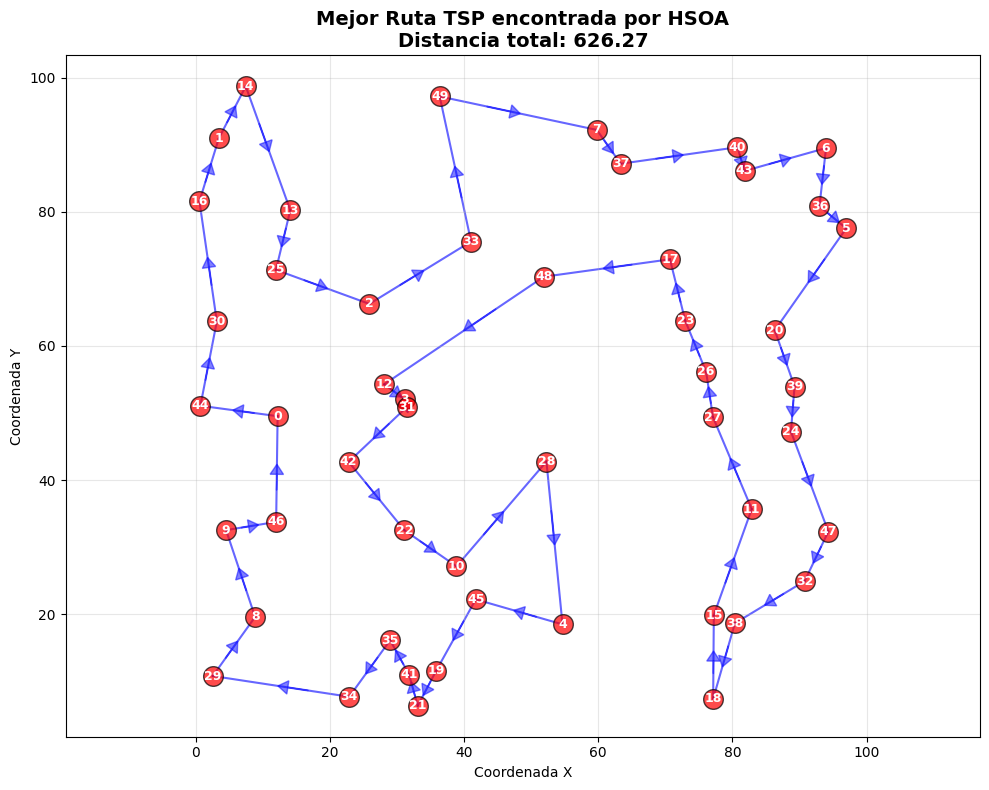

In [22]:
# Visualizar la mejor ruta encontrada
visualizar_ruta(mejor_ruta, COORDENADAS, mejor_distancia, 
                titulo="Mejor Ruta TSP encontrada por HSOA")

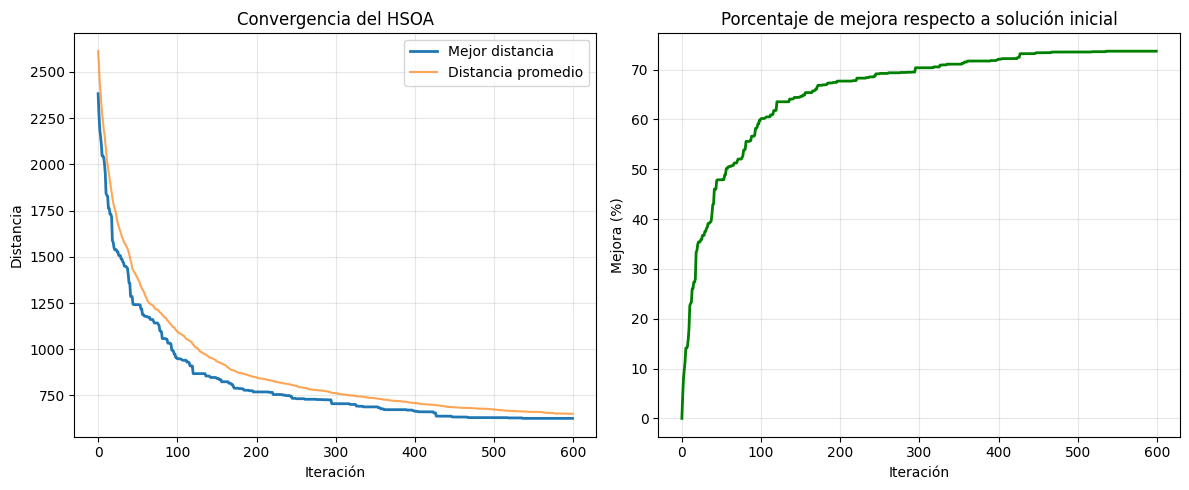

In [23]:
# Visualizar convergencia del algoritmo
hsoa.plot_convergencia()

## Análisis de Hiperparámetros

En esta sección analizaremos el impacto de diferentes hiperparámetros en el rendimiento del algoritmo HSOA:
- **sniffer_count**: Tamaño de la población
- **max_iteraciones**: Número de iteraciones del algoritmo
- **num_sonars**: Número de vecinos a evaluar en la fase de exploración (visión amplia del martillo)
- **prob_explotacion**: Probabilidad de combinar con la mejor ruta (explotación)


### 1. Análisis de `sniffer_count` (Tamaño de población)

In [ ]:
# Probar diferentes tamaños de población
tam_poblacions = [10, 20, 30, 40, 50, 75, 100]
resultados_sniffer = []

print("Analizando impacto de tam_poblacion...")
print("=" * 70)

for sc in tam_poblacions:
    print(f"\nProbando tam_poblacion = {sc}")

    # Crear nueva instancia de HSOA
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=sc,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=NUM_SONARS,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )

    # Ejecutar optimización
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()

    resultados_sniffer.append({
        'tam_poblacion': sc,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })

    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_sniffer[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de sniffer_count...

Probando sniffer_count = 10
  → Distancia final: 647.88
  → Mejora: 72.51%

Probando sniffer_count = 20
  → Distancia final: 610.17
  → Mejora: 75.64%

Probando sniffer_count = 30
  → Distancia final: 607.77
  → Mejora: 75.17%

Probando sniffer_count = 40
  → Distancia final: 604.22
  → Mejora: 74.43%

Probando sniffer_count = 50
  → Distancia final: 602.95
  → Mejora: 73.43%

Probando sniffer_count = 75
  → Distancia final: 598.33
  → Mejora: 74.67%

Probando sniffer_count = 100
  → Distancia final: 599.33
  → Mejora: 74.69%

Análisis completado ✓


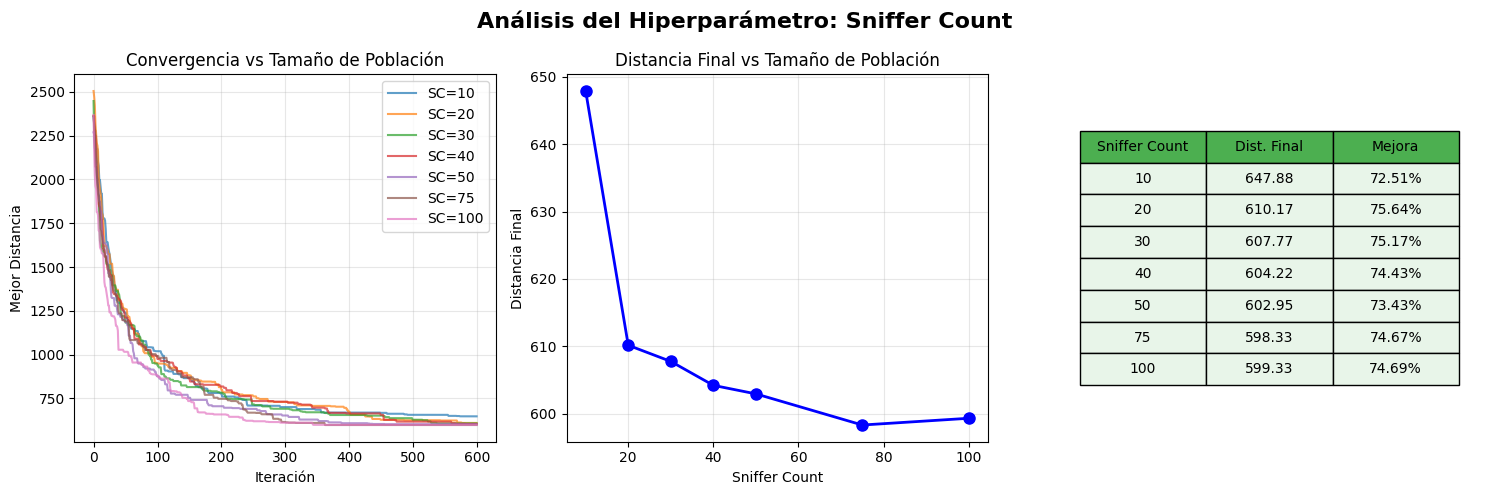

In [ ]:
# Visualizar resultados de tam_poblacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica 1: Convergencia para cada tam_poblacion
ax1 = axes[0]
for res in resultados_sniffer:
    ax1.plot(res['historial'], label=f"SC={res['tam_poblacion']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Tamaño de Población')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs tam_poblacion
ax2 = axes[1]
sc_values = [r['tam_poblacion'] for r in resultados_sniffer]
dist_finales = [r['distancia_final'] for r in resultados_sniffer]
ax2.plot(sc_values, dist_finales, 'o-', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Sniffer Count')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Tamaño de Población')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[r['tam_poblacion'], f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_sniffer]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Sniffer Count', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(sc_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#4CAF50')
        tabla[(i, 1)].set_facecolor('#4CAF50')
        tabla[(i, 2)].set_facecolor('#4CAF50')
    else:
        tabla[(i, 0)].set_facecolor('#E8F5E9')
        tabla[(i, 1)].set_facecolor('#E8F5E9')
        tabla[(i, 2)].set_facecolor('#E8F5E9')

plt.suptitle('Análisis del Hiperparámetro: Sniffer Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2. Análisis de `num_sonars` (Visión amplia del martillo)


In [ ]:
# Probar diferentes valores de num_sonars
num_sonars_values = [1, 3, 5, 7, 10, 15, 20, 25]
resultados_num_sonars = []

print("Analizando impacto de num_sonars...")
print("=" * 70)

for kv in num_sonars_values:
    print(f"\nProbando num_sonars = {kv}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=kv,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_num_sonars.append({
        'num_sonars': kv,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_num_sonars[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de k_vecinos...

Probando k_vecinos = 1
  → Distancia final: 768.10
  → Mejora: 67.41%

Probando k_vecinos = 3
  → Distancia final: 643.27
  → Mejora: 73.36%

Probando k_vecinos = 5
  → Distancia final: 607.37
  → Mejora: 74.81%

Probando k_vecinos = 7
  → Distancia final: 610.96
  → Mejora: 73.77%

Probando k_vecinos = 10
  → Distancia final: 603.26
  → Mejora: 72.61%

Probando k_vecinos = 15
  → Distancia final: 607.08
  → Mejora: 73.43%

Probando k_vecinos = 20
  → Distancia final: 596.49
  → Mejora: 75.53%

Probando k_vecinos = 25
  → Distancia final: 599.33
  → Mejora: 73.75%

Análisis completado ✓


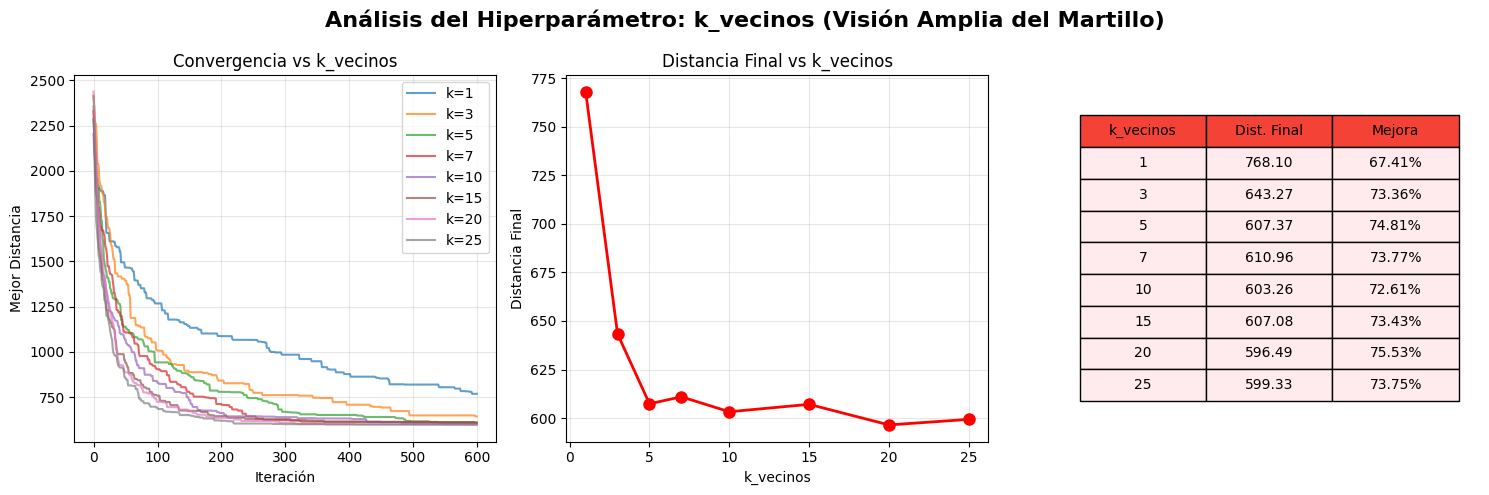

In [ ]:
# Visualizar resultados de num_sonars
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica 1: Convergencia para cada num_sonars
ax1 = axes[0]
for res in resultados_num_sonars:
    ax1.plot(res['historial'], label=f"k={res['num_sonars']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs num_sonars')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs num_sonars
ax2 = axes[1]
kv_values = [r['num_sonars'] for r in resultados_num_sonars]
dist_finales = [r['distancia_final'] for r in resultados_num_sonars]
ax2.plot(kv_values, dist_finales, 'o-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('num_sonars')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs num_sonars')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[f"{r['num_sonars']}", f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_num_sonars]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['num_sonars', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(kv_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#F44336')
        tabla[(i, 1)].set_facecolor('#F44336')
        tabla[(i, 2)].set_facecolor('#F44336')
    else:
        tabla[(i, 0)].set_facecolor('#FFEBEE')
        tabla[(i, 1)].set_facecolor('#FFEBEE')
        tabla[(i, 2)].set_facecolor('#FFEBEE')

plt.suptitle('Análisis del Hiperparámetro: num_sonars (Visión Amplia del Martillo)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 3. Análisis de `prob_explotacion` (Probabilidad de explotación)

In [ ]:
# Probar diferentes probabilidades de explotación
prob_explot = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
resultados_explot = []

print("Analizando impacto de prob_explotacion...")
print("=" * 70)

for px in prob_explot:
    print(f"\nProbando prob_explotacion = {px}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=NUM_SONARS,
        prob_explotacion=px,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_explot.append({
        'prob_explotacion': px,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_explot[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de prob_explotacion...

Probando prob_explotacion = 0.0
  → Distancia final: 634.45
  → Mejora: 74.15%

Probando prob_explotacion = 0.1
  → Distancia final: 633.39
  → Mejora: 72.73%

Probando prob_explotacion = 0.2
  → Distancia final: 641.97
  → Mejora: 72.88%

Probando prob_explotacion = 0.3
  → Distancia final: 599.64
  → Mejora: 73.98%

Probando prob_explotacion = 0.4
  → Distancia final: 600.83
  → Mejora: 73.83%

Probando prob_explotacion = 0.5
  → Distancia final: 615.43
  → Mejora: 74.52%

Probando prob_explotacion = 0.6
  → Distancia final: 606.14
  → Mejora: 74.26%

Probando prob_explotacion = 0.7
  → Distancia final: 606.09
  → Mejora: 73.73%

Probando prob_explotacion = 0.8
  → Distancia final: 630.49
  → Mejora: 74.52%

Análisis completado ✓


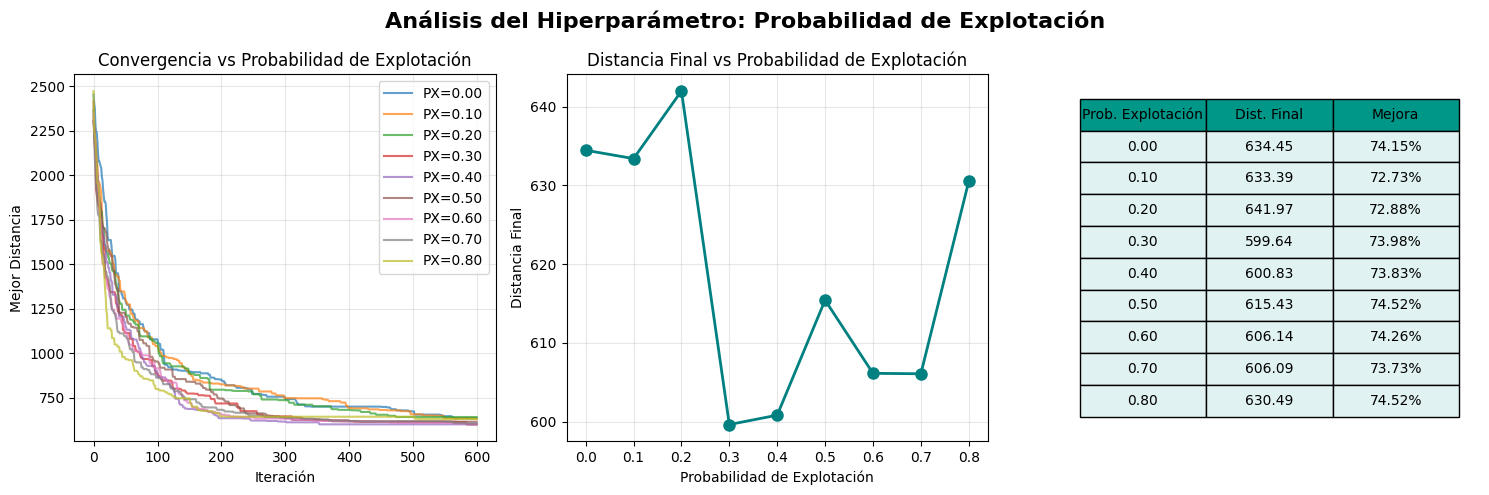

In [29]:
# Visualizar resultados de prob_explotacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica 1: Convergencia para cada prob_explotacion
ax1 = axes[0]
for res in resultados_explot:
    ax1.plot(res['historial'], label=f"PX={res['prob_explotacion']:.2f}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Probabilidad de Explotación')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs prob_explotacion
ax2 = axes[1]
px_values = [r['prob_explotacion'] for r in resultados_explot]
dist_finales = [r['distancia_final'] for r in resultados_explot]
ax2.plot(px_values, dist_finales, 'o-', linewidth=2, markersize=8, color='teal')
ax2.set_xlabel('Probabilidad de Explotación')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Probabilidad de Explotación')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[f"{r['prob_explotacion']:.2f}", f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_explot]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Prob. Explotación', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(px_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#009688')
        tabla[(i, 1)].set_facecolor('#009688')
        tabla[(i, 2)].set_facecolor('#009688')
    else:
        tabla[(i, 0)].set_facecolor('#E0F2F1')
        tabla[(i, 1)].set_facecolor('#E0F2F1')
        tabla[(i, 2)].set_facecolor('#E0F2F1')

plt.suptitle('Análisis del Hiperparámetro: Probabilidad de Explotación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4. Análisis de `max_iteraciones` (Número de iteraciones)

In [ ]:
# Probar diferentes números de iteraciones
max_iters = [50, 100, 200, 300, 500, 750, 1000]
resultados_iters = []

print("Analizando impacto de max_iteraciones...")
print("=" * 70)

for mi in max_iters:
    print(f"\nProbando max_iteraciones = {mi}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=mi,
        num_sonars=NUM_SONARS,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_iters.append({
        'max_iteraciones': mi,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_iters[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de max_iteraciones...

Probando max_iteraciones = 50
  → Distancia final: 1113.80
  → Mejora: 51.88%

Probando max_iteraciones = 100
  → Distancia final: 934.63
  → Mejora: 58.23%

Probando max_iteraciones = 200
  → Distancia final: 798.56
  → Mejora: 66.73%

Probando max_iteraciones = 300
  → Distancia final: 737.96
  → Mejora: 67.58%

Probando max_iteraciones = 500
  → Distancia final: 650.13
  → Mejora: 73.30%

Probando max_iteraciones = 750
  → Distancia final: 606.09
  → Mejora: 75.11%

Probando max_iteraciones = 1000
  → Distancia final: 596.18
  → Mejora: 75.61%

Análisis completado ✓


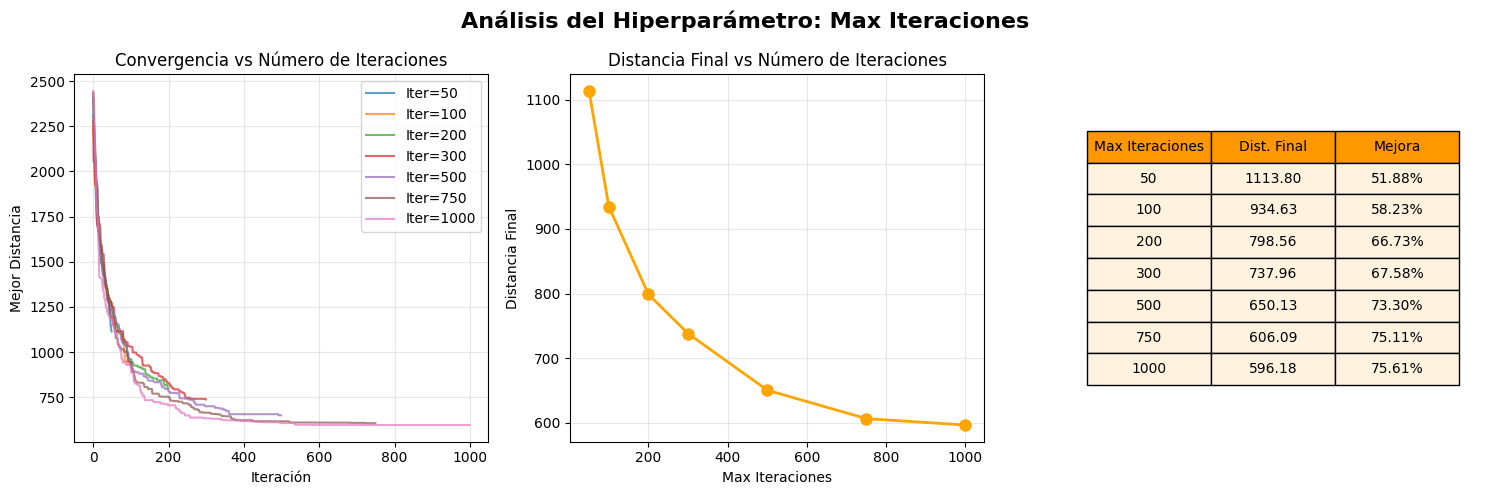

In [31]:
# Visualizar resultados de max_iteraciones
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica 1: Convergencia para cada max_iteraciones
ax1 = axes[0]
for res in resultados_iters:
    ax1.plot(res['historial'], label=f"Iter={res['max_iteraciones']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Número de Iteraciones')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs max_iteraciones
ax2 = axes[1]
iter_values = [r['max_iteraciones'] for r in resultados_iters]
dist_finales = [r['distancia_final'] for r in resultados_iters]
ax2.plot(iter_values, dist_finales, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Max Iteraciones')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Número de Iteraciones')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[r['max_iteraciones'], f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_iters]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Max Iteraciones', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(iter_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#FF9800')
        tabla[(i, 1)].set_facecolor('#FF9800')
        tabla[(i, 2)].set_facecolor('#FF9800')
    else:
        tabla[(i, 0)].set_facecolor('#FFF3E0')
        tabla[(i, 1)].set_facecolor('#FFF3E0')
        tabla[(i, 2)].set_facecolor('#FFF3E0')

plt.suptitle('Análisis del Hiperparámetro: Max Iteraciones', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
# Algoritmo Genético para TSP

def crossover(parent1, parent2):
    """Cruce de orden (Order Crossover, OX)."""
    n = len(parent1)
    start, end = sorted(random.sample(range(n), 2))
    child = [-1] * n
    child[start:end + 1] = parent1[start:end + 1]

    pointer = 0
    for city in parent2:
        if city not in child:
            while child[pointer] != -1:
                pointer += 1
            child[pointer] = city
    return child


def mutate(route, mutation_rate=0.1):
    """Mutación por intercambio."""
    r = route.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(r)), 2)
        r[i], r[j] = r[j], r[i]
    return r


def AG_TSP(matriz_distancias, pop_size, num_iter, mutation_rate):
    """Algoritmo Genético para TSP."""
    n_cities = len(matriz_distancias)

    def route_distance(route):
        """Calcula la distancia total de una ruta."""
        return sum(matriz_distancias[route[i], route[(i + 1) % n_cities]] for i in range(n_cities))

    # Inicializar población
    population = [random.sample(range(n_cities), n_cities) for _ in range(pop_size)]
    best_route = min(population, key=route_distance)
    best_distance = route_distance(best_route)
    history = [best_distance]

    for it in range(num_iter):
        # Evaluar fitness
        ranked = sorted(population, key=route_distance)
        elites = ranked[:int(0.2 * pop_size)]  # mantener los mejores 20%

        # Generar descendencia
        children = []
        while len(children) < pop_size - len(elites):
            p1, p2 = random.sample(elites, 2)
            child = crossover(p1, p2)
            child = mutate(child, mutation_rate)
            children.append(child)

        population = elites + children
        current_best = min(population, key=route_distance)
        current_best_dist = route_distance(current_best)

        if current_best_dist < best_distance:
            best_distance = current_best_dist
            best_route = current_best

        history.append(best_distance)

    return best_route, best_distance, history




=== COMPARACIÓN FINAL ENTRE HSOA OPTIMIZADO Y GA ===
HSOA Optimizado -> Distancia: 616.28, Tiempo: 1.2263 s
GA              -> Distancia: 1095.96, Tiempo: 0.6338 s


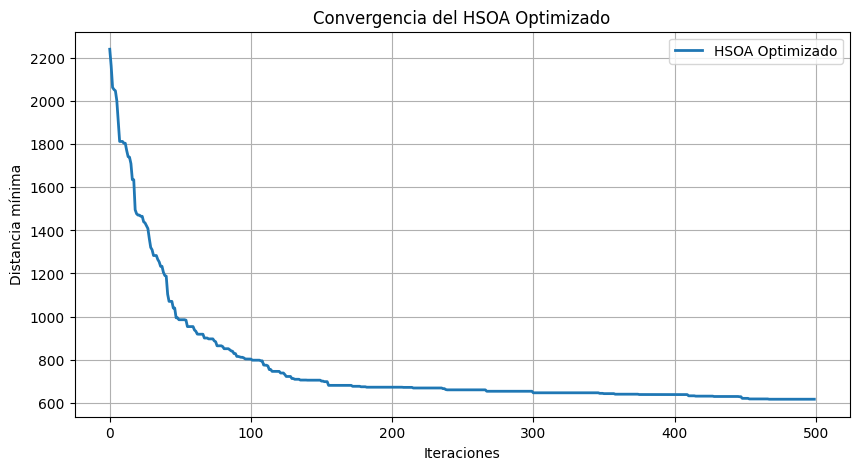

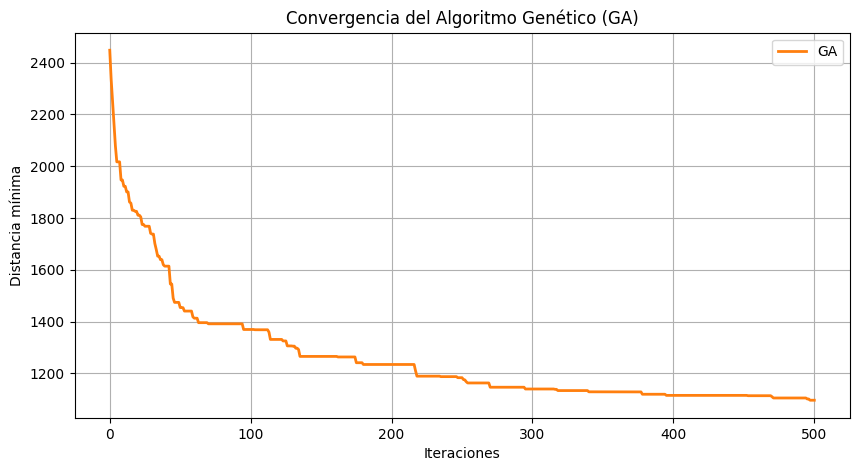

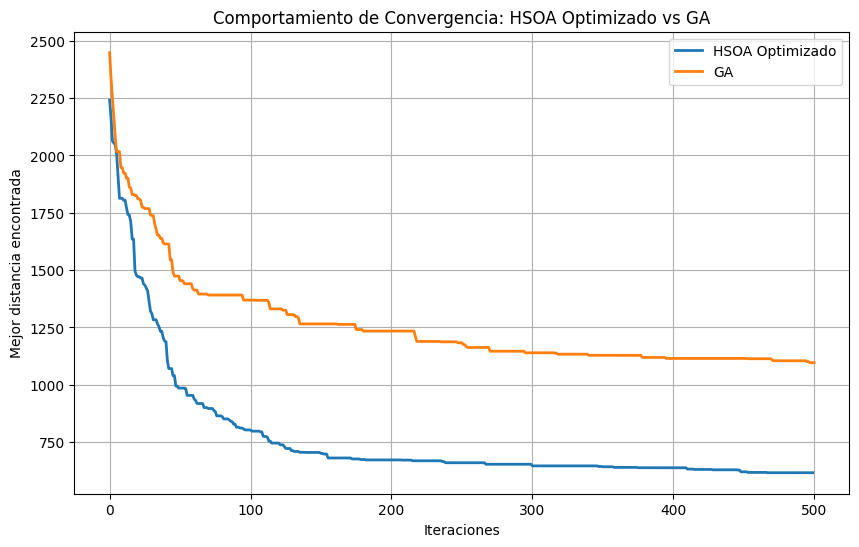

In [ ]:
# ============================================================
# COMPARACIÓN ENTRE HSOA OPTIMIZADO Y ALGORITMO GENÉTICO (GA)
# ============================================================

# --- Ejecutar HSOA Optimizado ---
start_time = time.time()
hsoa = HSOA_TSP(
    matriz_distancias=MATRIZ_DISTANCIAS,
    tam_poblacion=30,
    max_iteraciones=500,
    num_sonars=5,
    prob_explotacion=0.7,
    verbose=False
)

mejor_ruta_hsoa, mejor_distancia_hsoa = hsoa.optimizar()
time_hsoa = time.time() - start_time

# --- Ejecutar Algoritmo Genético (GA) ---
start_time = time.time()
mejor_ruta_ga, mejor_distancia_ga, historial_ga = AG_TSP(
    matriz_distancias=MATRIZ_DISTANCIAS,
    pop_size=30,
    num_iter=500,
    mutation_rate=0.1
)
time_ga = time.time() - start_time
time_ga = time.time() - start_time
# ============================================================
# RESULTADOS COMPARATIVOS
# ============================================================

print("\n=== COMPARACIÓN FINAL ENTRE HSOA OPTIMIZADO Y GA ===")
print(f"HSOA Optimizado -> Distancia: {mejor_distancia_hsoa:.2f}, Tiempo: {time_hsoa:.4f} s")
print(f"GA              -> Distancia: {mejor_distancia_ga:.2f}, Tiempo: {time_ga:.4f} s")

# ============================================================
# GRÁFICOS DE CONVERGENCIA
# ============================================================

# Gráfico individual del HSOA Optimizado
plt.figure(figsize=(10, 5))
plt.plot(hsoa.historial_mejor, label='HSOA Optimizado', linewidth=2, color='tab:blue')
plt.title('Convergencia del HSOA Optimizado')
plt.xlabel('Iteraciones')
plt.ylabel('Distancia mínima')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico individual del GA
plt.figure(figsize=(10, 5))
plt.plot(historial_ga, label='GA', linewidth=2, color='tab:orange')
plt.title('Convergencia del Algoritmo Genético (GA)')
plt.xlabel('Iteraciones')
plt.ylabel('Distancia mínima')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico comparativo HSOA vs GA
plt.figure(figsize=(10, 6))
plt.plot(hsoa.historial_mejor, label='HSOA Optimizado', linewidth=2, color='tab:blue')
plt.plot(historial_ga, label='GA', linewidth=2, color='tab:orange')
plt.title('Comportamiento de Convergencia: HSOA Optimizado vs GA')
plt.xlabel('Iteraciones')
plt.ylabel('Mejor distancia encontrada')
plt.legend()
plt.grid(True)
plt.show()


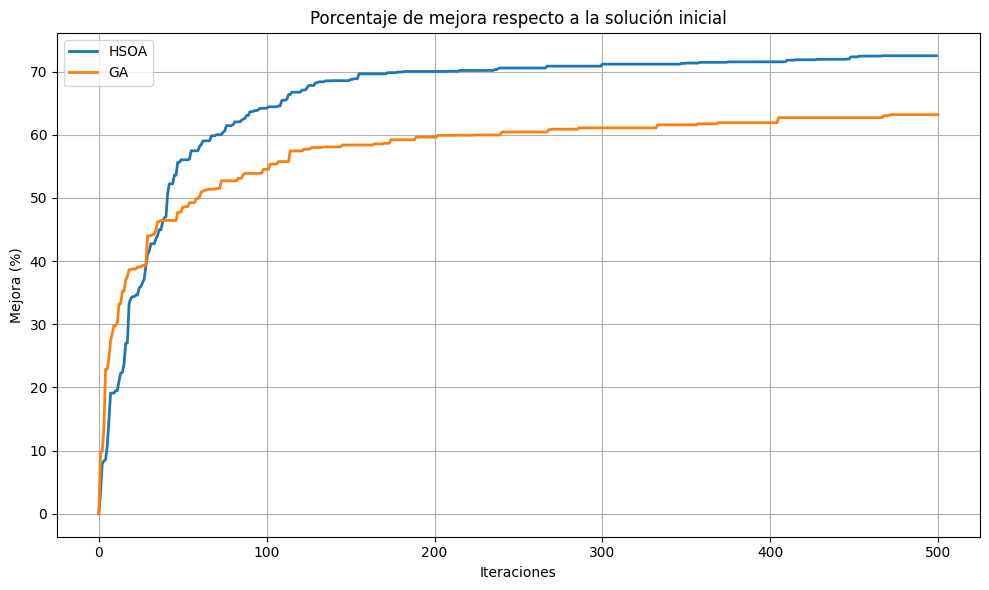

In [44]:
# ============================================================
# PORCENTAJE DE MEJORA RESPECTO A LA SOLUCIÓN INICIAL (HSOA vs GA)
# ============================================================

# --- HSOA ---
hist_hsoa = np.array(hsoa.historial_mejor)
mejora_hsoa = (hist_hsoa[0] - hist_hsoa) / hist_hsoa[0] * 100

# --- GA ---
hist_ga = np.array(historial_ga)
mejora_ga = (hist_ga[0] - hist_ga) / hist_ga[0] * 100

# --- Plot conjunto ---
plt.figure(figsize=(10,6))
plt.plot(mejora_hsoa, label='HSOA', linewidth=2, color='tab:blue')
plt.plot(mejora_ga, label='GA', linewidth=2, color='tab:orange')

plt.title('Porcentaje de mejora respecto a la solución inicial')
plt.xlabel('Iteraciones')
plt.ylabel('Mejora (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Analizando impacto de num_iter en GA...

Probando num_iter = 50
  → Distancia final: 1558.74
  → Mejora: 34.93%
  → Tiempo: 0.04 s

Probando num_iter = 100
  → Distancia final: 1289.85
  → Mejora: 45.56%
  → Tiempo: 0.06 s

Probando num_iter = 200
  → Distancia final: 1205.81
  → Mejora: 50.48%
  → Tiempo: 0.13 s

Probando num_iter = 300
  → Distancia final: 1258.73
  → Mejora: 50.23%
  → Tiempo: 0.18 s

Probando num_iter = 500
  → Distancia final: 908.97
  → Mejora: 60.63%
  → Tiempo: 0.32 s

Probando num_iter = 750
  → Distancia final: 1016.78
  → Mejora: 56.08%
  → Tiempo: 0.47 s

Probando num_iter = 1000
  → Distancia final: 1009.38
  → Mejora: 59.09%
  → Tiempo: 0.63 s

Análisis completado.


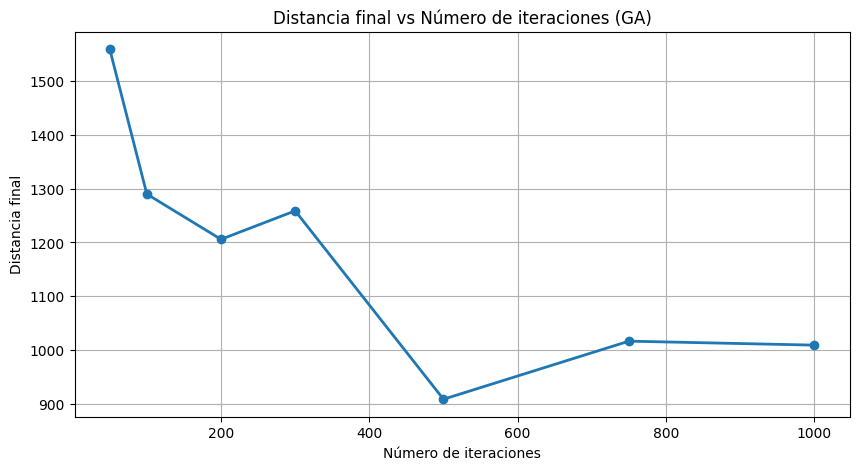

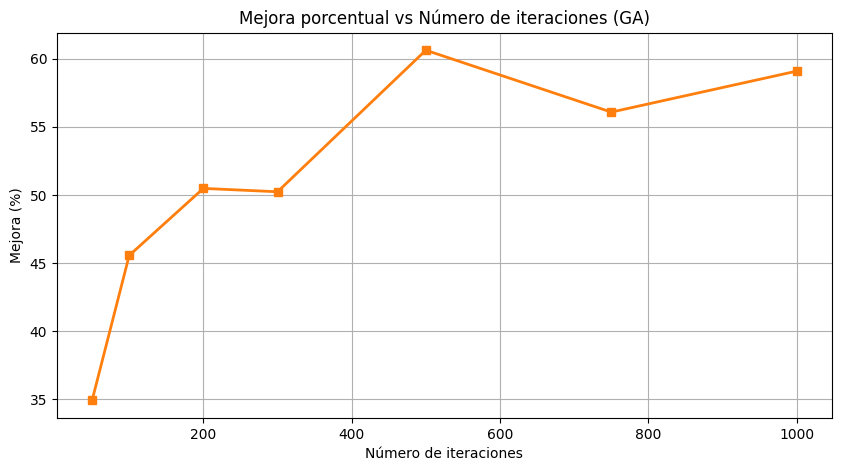

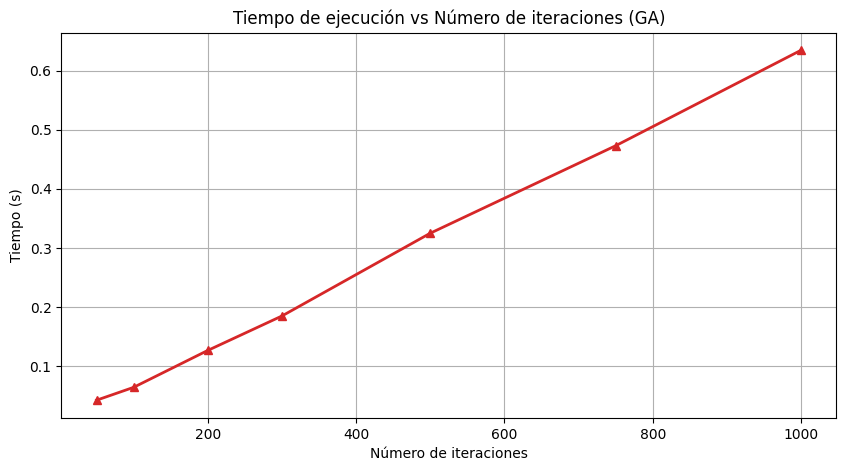

In [39]:
# ============================================================
# ANÁLISIS DEL IMPACTO DE NUMERO DE ITERACIONES EN EL GA
# ============================================================

max_iters = [50, 100, 200, 300, 500, 750, 1000]
resultados_ga_iters = []

print("Analizando impacto de num_iter en GA...")
print("=" * 70)

for mi in max_iters:
    print(f"\nProbando num_iter = {mi}")

    start_time = time.time()
    mejor_ruta_ga, mejor_dist_ga, historial_ga = AG_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        pop_size=30,
        num_iter=mi,
        mutation_rate=0.1
    )
    time_ga = time.time() - start_time

    mejora = (historial_ga[0] - historial_ga[-1]) / historial_ga[0] * 100

    resultados_ga_iters.append({
        'num_iter': mi,
        'mejor_distancia': mejor_dist_ga,
        'historial': historial_ga,
        'distancia_final': historial_ga[-1],
        'mejora': mejora,
        'tiempo': time_ga
    })

    print(f"  → Distancia final: {mejor_dist_ga:.2f}")
    print(f"  → Mejora: {mejora:.2f}%")
    print(f"  → Tiempo: {time_ga:.2f} s")

print("\n" + "=" * 70)
print("Análisis completado.")

# ============================================================
# GRÁFICOS DE ANÁLISIS DE RENDIMIENTO DEL GA
# ============================================================

# Distancia final vs número de iteraciones
plt.figure(figsize=(10,5))
plt.plot([r['num_iter'] for r in resultados_ga_iters],
         [r['distancia_final'] for r in resultados_ga_iters],
         marker='o', linewidth=2)
plt.title('Distancia final vs Número de iteraciones (GA)')
plt.xlabel('Número de iteraciones')
plt.ylabel('Distancia final')
plt.grid(True)
plt.show()

# Mejora porcentual vs número de iteraciones
plt.figure(figsize=(10,5))
plt.plot([r['num_iter'] for r in resultados_ga_iters],
         [r['mejora'] for r in resultados_ga_iters],
         marker='s', linewidth=2, color='tab:orange')
plt.title('Mejora porcentual vs Número de iteraciones (GA)')
plt.xlabel('Número de iteraciones')
plt.ylabel('Mejora (%)')
plt.grid(True)
plt.show()

# Tiempo de ejecución vs número de iteraciones
plt.figure(figsize=(10,5))
plt.plot([r['num_iter'] for r in resultados_ga_iters],
         [r['tiempo'] for r in resultados_ga_iters],
         marker='^', linewidth=2, color='tab:red')
plt.title('Tiempo de ejecución vs Número de iteraciones (GA)')
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo (s)')
plt.grid(True)
plt.show()


Analizando impacto de pop_size en GA...

Probando pop_size = 10
  → Distancia final: 1231.01
  → Mejora: 51.46%
  → Tiempo: 0.12 s

Probando pop_size = 20
  → Distancia final: 1076.08
  → Mejora: 53.41%
  → Tiempo: 0.21 s

Probando pop_size = 30
  → Distancia final: 1099.45
  → Mejora: 54.58%
  → Tiempo: 0.33 s

Probando pop_size = 40
  → Distancia final: 1008.68
  → Mejora: 57.06%
  → Tiempo: 0.44 s

Probando pop_size = 50
  → Distancia final: 891.41
  → Mejora: 62.86%
  → Tiempo: 0.73 s

Probando pop_size = 75
  → Distancia final: 821.69
  → Mejora: 65.40%
  → Tiempo: 1.08 s

Probando pop_size = 100
  → Distancia final: 855.85
  → Mejora: 63.18%
  → Tiempo: 1.09 s

Análisis completado.


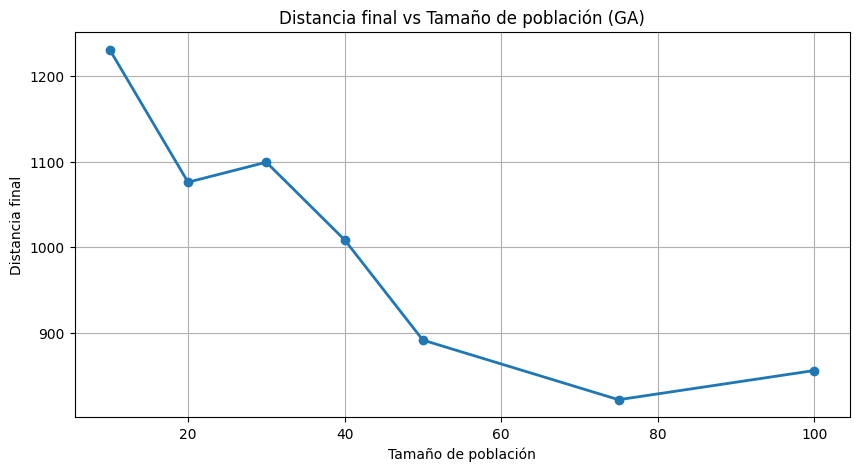

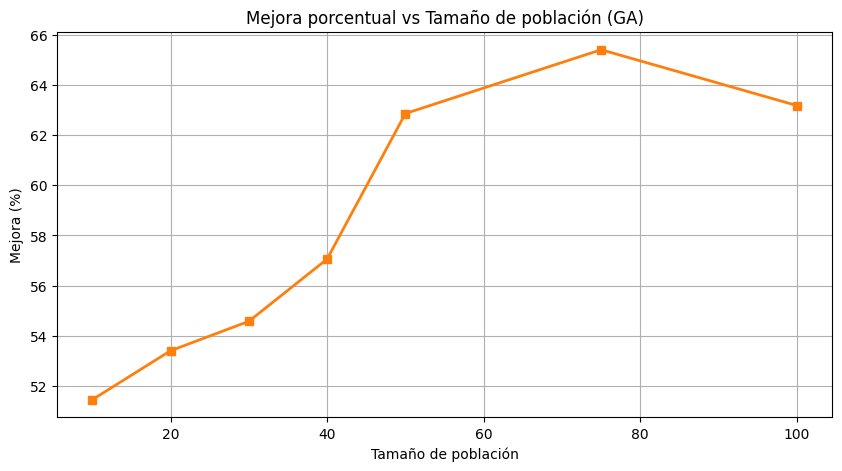

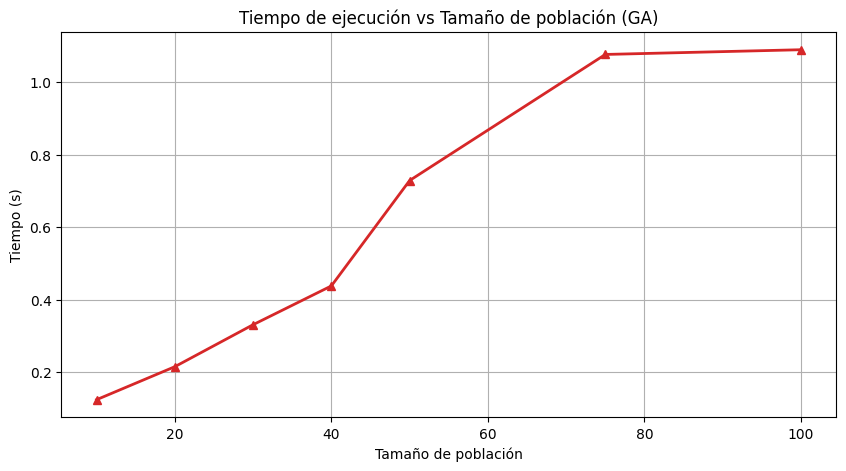

In [40]:
# ============================================================
# ANÁLISIS DEL IMPACTO DEL TAMAÑO DE POBLACIÓN EN EL GA
# ============================================================

pop_sizes = [10, 20, 30, 40, 50, 75, 100]
resultados_ga_pop = []

print("Analizando impacto de pop_size en GA...")
print("=" * 70)

for ps in pop_sizes:
    print(f"\nProbando pop_size = {ps}")

    start_time = time.time()
    mejor_ruta_ga, mejor_dist_ga, historial_ga = AG_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        pop_size=ps,
        num_iter=500,
        mutation_rate=0.1
    )
    time_ga = time.time() - start_time

    mejora = (historial_ga[0] - historial_ga[-1]) / historial_ga[0] * 100

    resultados_ga_pop.append({
        'pop_size': ps,
        'mejor_distancia': mejor_dist_ga,
        'historial': historial_ga,
        'distancia_final': historial_ga[-1],
        'mejora': mejora,
        'tiempo': time_ga
    })

    print(f"  → Distancia final: {mejor_dist_ga:.2f}")
    print(f"  → Mejora: {mejora:.2f}%")
    print(f"  → Tiempo: {time_ga:.2f} s")

print("\n" + "=" * 70)
print("Análisis completado.")

# ============================================================
# GRÁFICOS DE ANÁLISIS DE RENDIMIENTO DEL GA (Tamaño de población)
# ============================================================

# Distancia final vs tamaño de población
plt.figure(figsize=(10,5))
plt.plot([r['pop_size'] for r in resultados_ga_pop],
         [r['distancia_final'] for r in resultados_ga_pop],
         marker='o', linewidth=2)
plt.title('Distancia final vs Tamaño de población (GA)')
plt.xlabel('Tamaño de población')
plt.ylabel('Distancia final')
plt.grid(True)
plt.show()

# Mejora porcentual vs tamaño de población
plt.figure(figsize=(10,5))
plt.plot([r['pop_size'] for r in resultados_ga_pop],
         [r['mejora'] for r in resultados_ga_pop],
         marker='s', linewidth=2, color='tab:orange')
plt.title('Mejora porcentual vs Tamaño de población (GA)')
plt.xlabel('Tamaño de población')
plt.ylabel('Mejora (%)')
plt.grid(True)
plt.show()

# Tiempo de ejecución vs tamaño de población
plt.figure(figsize=(10,5))
plt.plot([r['pop_size'] for r in resultados_ga_pop],
         [r['tiempo'] for r in resultados_ga_pop],
         marker='^', linewidth=2, color='tab:red')
plt.title('Tiempo de ejecución vs Tamaño de población (GA)')
plt.xlabel('Tamaño de población')
plt.ylabel('Tiempo (s)')
plt.grid(True)
plt.show()


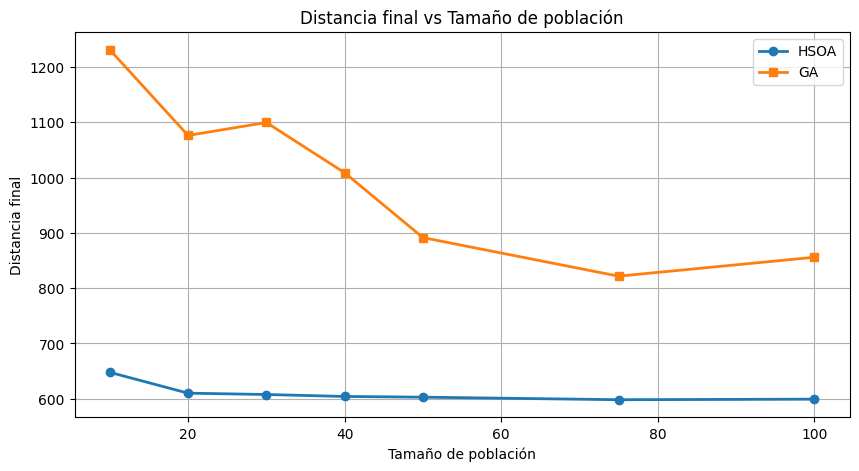

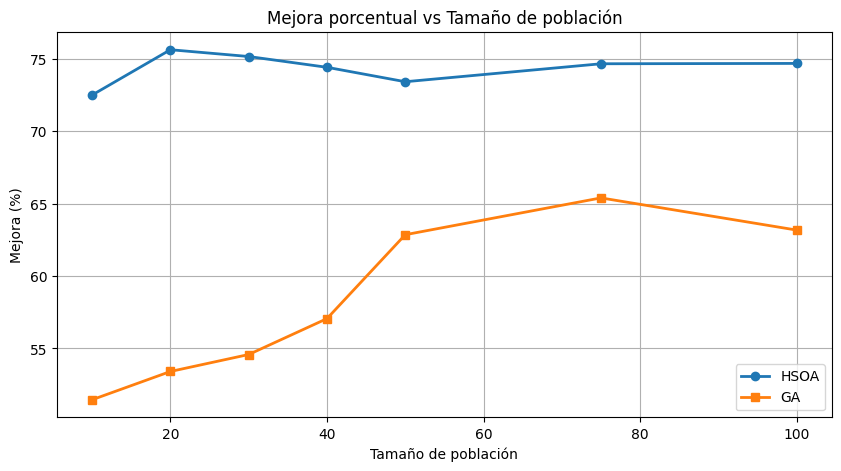

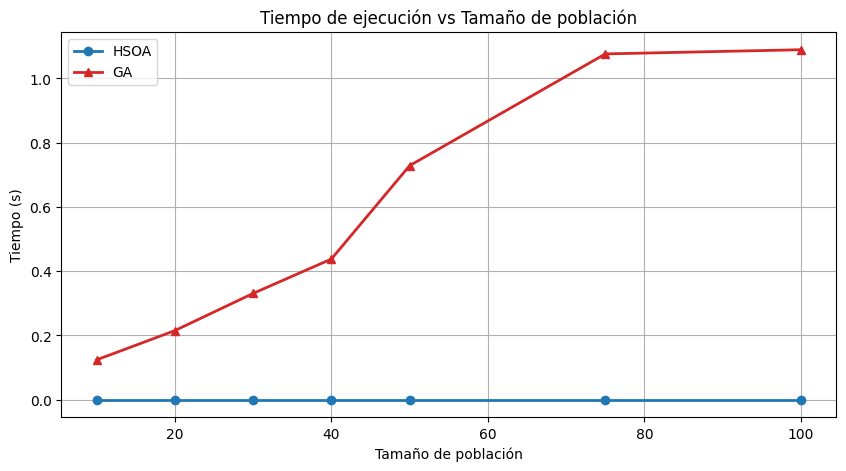

In [ ]:
# ============================================================
# COMPARACIÓN VISUAL: HSOA vs GA (Tamaño de población)
# ============================================================

# Asegúrate de haber ejecutado los análisis previos:
# - resultados_sniffer  →  resultados del HSOA
# - resultados_ga_pop   →  resultados del GA

# Tamaños de población
sizes_hsoa = [r['tam_poblacion'] for r in resultados_sniffer]
sizes_ga = [r['pop_size'] for r in resultados_ga_pop]

# Distancias finales
dist_hsoa = [r['distancia_final'] for r in resultados_sniffer]
dist_ga = [r['distancia_final'] for r in resultados_ga_pop]

# Mejoras porcentuales
mejora_hsoa = [r['mejora'] for r in resultados_sniffer]
mejora_ga = [r['mejora'] for r in resultados_ga_pop]

# Tiempos de ejecución
tiempo_hsoa = [r.get('tiempo', 0) for r in resultados_sniffer]  # por si no se guardó tiempo
tiempo_ga = [r['tiempo'] for r in resultados_ga_pop]

# ============================================================
# 1. Distancia final vs tamaño de población
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(sizes_hsoa, dist_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(sizes_ga, dist_ga, marker='s', linewidth=2, label='GA')
plt.title('Distancia final vs Tamaño de población')
plt.xlabel('Tamaño de población')
plt.ylabel('Distancia final')
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 2. Mejora porcentual vs tamaño de población
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(sizes_hsoa, mejora_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(sizes_ga, mejora_ga, marker='s', linewidth=2, label='GA', color='tab:orange')
plt.title('Mejora porcentual vs Tamaño de población')
plt.xlabel('Tamaño de población')
plt.ylabel('Mejora (%)')
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 3. Tiempo de ejecución vs tamaño de población
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(sizes_hsoa, tiempo_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(sizes_ga, tiempo_ga, marker='^', linewidth=2, label='GA', color='tab:red')
plt.title('Tiempo de ejecución vs Tamaño de población')
plt.xlabel('Tamaño de población')
plt.ylabel('Tiempo (s)')
plt.legend()
plt.grid(True)
plt.show()


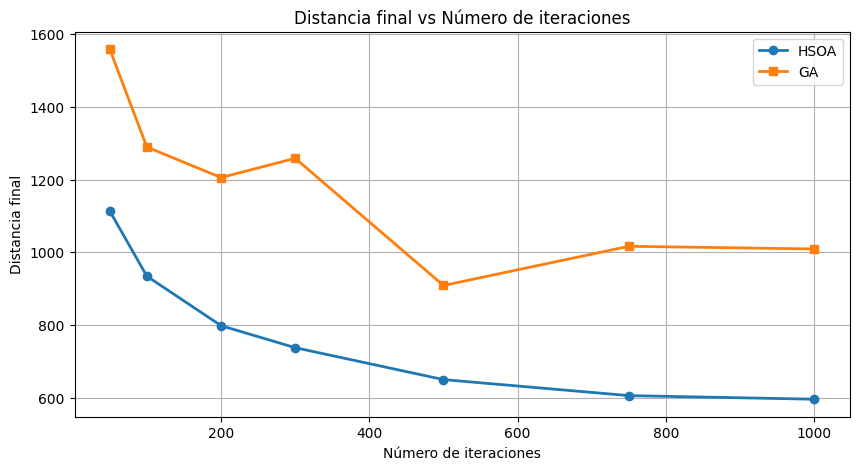

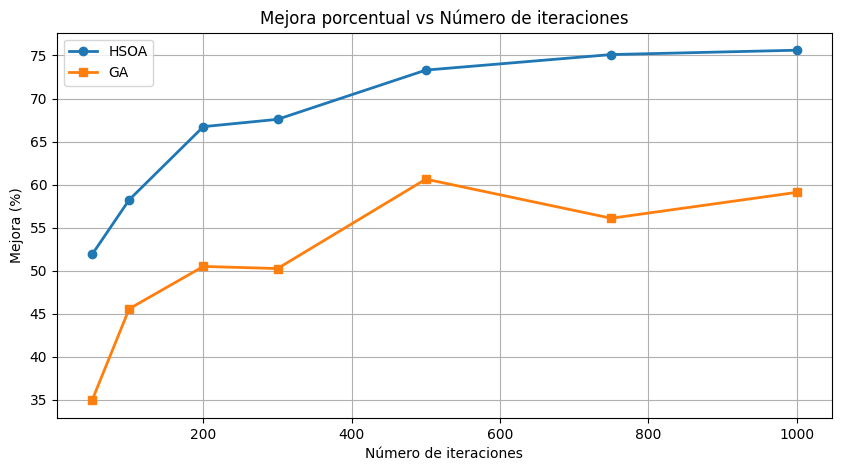

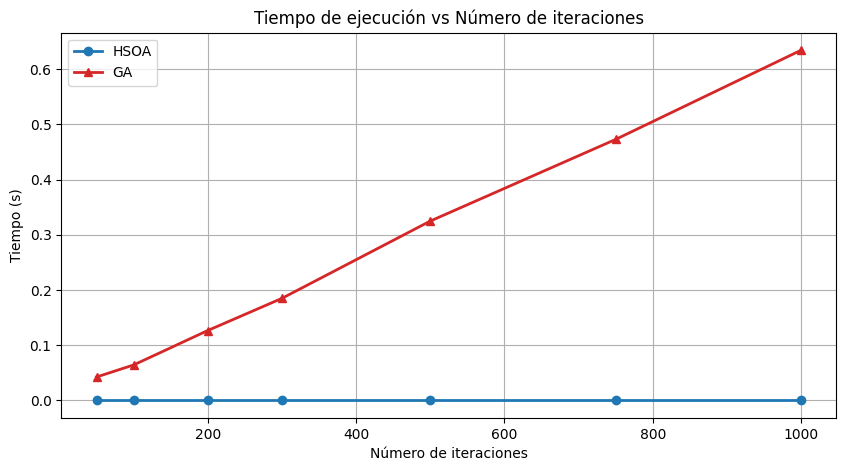

In [42]:
# ============================================================
# COMPARACIÓN VISUAL: HSOA vs GA (Número de iteraciones)
# ============================================================

# Asegúrate de haber ejecutado previamente:
# - resultados_iters       → resultados del HSOA
# - resultados_ga_iters    → resultados del GA

# Número de iteraciones
iters_hsoa = [r['max_iteraciones'] for r in resultados_iters]
iters_ga = [r['num_iter'] for r in resultados_ga_iters]

# Distancias finales
dist_hsoa = [r['distancia_final'] for r in resultados_iters]
dist_ga = [r['distancia_final'] for r in resultados_ga_iters]

# Mejoras porcentuales
mejora_hsoa = [r['mejora'] for r in resultados_iters]
mejora_ga = [r['mejora'] for r in resultados_ga_iters]

# Tiempos de ejecución
tiempo_hsoa = [r.get('tiempo', 0) for r in resultados_iters]  # por si no se guardó tiempo
tiempo_ga = [r['tiempo'] for r in resultados_ga_iters]

# ============================================================
# 1. Distancia final vs número de iteraciones
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(iters_hsoa, dist_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(iters_ga, dist_ga, marker='s', linewidth=2, label='GA')
plt.title('Distancia final vs Número de iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Distancia final')
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 2. Mejora porcentual vs número de iteraciones
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(iters_hsoa, mejora_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(iters_ga, mejora_ga, marker='s', linewidth=2, label='GA', color='tab:orange')
plt.title('Mejora porcentual vs Número de iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Mejora (%)')
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 3. Tiempo de ejecución vs número de iteraciones
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(iters_hsoa, tiempo_hsoa, marker='o', linewidth=2, label='HSOA')
plt.plot(iters_ga, tiempo_ga, marker='^', linewidth=2, label='GA', color='tab:red')
plt.title('Tiempo de ejecución vs Número de iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo (s)')
plt.legend()
plt.grid(True)
plt.show()
